<a target="_blank" href="https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Mamba Visualizations

Various mamba visualizations

In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
import plotly.offline as pyo
pyo.init_notebook_mode()
import matplotlib
%matplotlib inline
# comment this out if you get errors
#%matplotlib ipymplf
# do pip install nodejs-bin
# install node.js
# follow these instructions https://stackoverflow.com/a/56416229
# this gives u nice hover stuff
# not needed, if you get an error feel free to comment it out
#pio.renderers.default = "colab"
#pio.renderers.default = "notebook_connected"
#print(f"Using renderer: {pio.renderers.default}")
# Import stuff
import torch
from functools import partial
import transformer_lens.utils as utils
import plotly.express as px
torch.set_grad_enabled(False)
device = utils.get_device()
# from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [ ]:
# load mamba
import mamba
from importlib import reload
reload(mamba)
model = mamba.HookedMamba.from_pretrained("state-spaces/mamba-370m", device=device)

## Full model visualizations

In [ ]:

%matplotlib inline
from ipywidgets import interact
import plotly.graph_objects as go
from PIL import Image, ImageDraw, ImageFont
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from  IPython.display import display
from einops import rearrange, repeat, einsum
from collections import defaultdict
import torch.nn.functional as F
import tqdm
import IPython

# test


import mplcursors
import colorsys

FONT_SIZE = 60
prompt_full = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_full = model.to_tokens(prompt_full)
logits_full, activations_full = model.run_with_cache(prompt_tokens_full)
token_labels_full = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_full[0]))]

# [V,D]
embed = model.embedding.weight
V,D = embed.size()

# [V]
embed_sizes = torch.linalg.norm(embed, ord=2, dim=1)
# no divide by zero
embed_sizes[embed_sizes==0] = 1.0
# [V,D]
normalized_embed = embed / embed_sizes.view(V,1)

def tok_to_str(tok):
    if type(tok) is torch.tensor:
        tok = tok.item()
    return model.to_str_tokens(torch.tensor([tok]))[0]

#                       [K,D]    D is model.cfg.D, K is number of vecs we are comparing
def find_closest_embeds(vecs):
    if len(vecs.size()) == 1:
        vecs = vecs.view(1,D)
    K,D = vecs.size()
    
    # [K,1]
    vecs_norm = torch.linalg.norm(vecs, ord=2,dim=1, keepdim=True)
    # no divide by zero
    vecs_norm[vecs_norm==0] = 1.0
    # [K,D]          [K,D]    [K,1]
    normalized_vecs = vecs / vecs_norm

    # [V,K]         [V,D]            [D,K]
    dot_prods = normalized_embed @ normalized_vecs.T

    # [V,K]
    sorted_closest = torch.argsort(-dot_prods, dim=0)

    #       [K,V]              [K,V]
    return sorted_closest.T, dot_prods.T

if not 'diff_mag_lookup' in globals():
    global diff_mag_lookup
    diff_mag_lookup = None

# K is number of inputs, each of size D
#                          [K,D]
def compare_to_differences(vecs, top_to_keep=2):
    batch_size = 200
    lookup_batch_size = 40 # needs to be smaller

    if len(vecs.size()) == 1: # expand to K dim
        vecs = vecs.view(1,D)
    if len(vecs.size()) == 3: # remove batch dim
        if vecs.size()[0] > 1: raise Exception(f"only works for batch size = 1, you have input size {vecs.size()}")
        vecs = vecs[0]

    # normalize input
    norms = torch.linalg.norm(vecs, ord=2, dim=1, keepdim=True)
    norms[norms==0] = 1 # don't divide by 0
    vecs = vecs / norms
    
    K,D = vecs.size()
    
    top_scores = torch.zeros([K,0], device=model.cfg.device)
    top_indices = torch.zeros([K,0,2], device=model.cfg.device, dtype=torch.int64)
    
    arangeK = torch.arange(K, device=model.cfg.device)


    # We will do an optimization here
    # assume x is normalized
    # (x dot (a-b))/norm(a-b)
    # = (x dot a - x dot b)/norm(a-b)

    # thus we only need all x dot embed (small and ez)
    # and a [V,V] lookup of all the norms of a-b
    # that lookup is big, but not too big (~10GB of memory)

    global diff_mag_lookup
    if diff_mag_lookup is None:
        diff_mag_lookup = torch.zeros([V,V], device=model.cfg.device)
        print("computing diff mag lookup")
        for batch_start in tqdm.tqdm(list(range(0, V, lookup_batch_size))):
            batch_end = min(batch_start+lookup_batch_size, V)
            cur_batch_size = batch_end-batch_start
            a        = embed[batch_start:batch_end]
            b        = embed
            # uses this trick https://stackoverflow.com/questions/53442069/how-to-vectorize-the-following-python-code/53442187#53442187
            # because it copies the 1 axes until they match the other dim, this has the effect of:
            # res[i,j] is a[i] - b[j]
            # [batch_size, V, D]
            diffs              = a.view(cur_batch_size,1,D)-b.view(1,V,D)
            # [batch_size, V]
            norms = torch.linalg.norm(diffs, ord=2, dim=2)
            norms[norms==0.0] = 1.0 # no divide by zero!
            diff_mag_lookup[batch_start:batch_end,:] = norms
    # K,V       [K,D]   [V,D]
    dot_prods = vecs @ embed.T

    for batch_start in tqdm.tqdm(list(range(0, V, batch_size))):   
        batch_end = min(batch_start+batch_size, V)
        cur_batch_size = batch_end-batch_start
        # [K, batch, V]   
        x_dot_a_minus_b = dot_prods[:,batch_start:batch_end].view(K, cur_batch_size, 1) - dot_prods[:].view(K, 1, V)
        # [K, batch, V]                 [batch, V]
        x_dot_a_minus_b /= diff_mag_lookup[batch_start:batch_end,:].view(1, cur_batch_size, V)
        
        # [K,batch*V] where [k,i*V+j] = = vecs[k].dot(normalize(a[i] - b[j]))
        res2 = x_dot_a_minus_b.flatten(start_dim=1)
        # get top_to_keep for each k
        # [K,top_to_keep]
        scores, inds = torch.topk(-res2, dim=1, k=top_to_keep)
    
        # decode those into tuple indices
        # [K,top_to_keep]
        i                = inds // V + batch_start # + batch_start is because of how a is formed
        # [K,top_to_keep]
        j                = inds % V
    
        # I can't figure out how to do this and only index the right stuff
        # this way is inefficient but it's a small number of things so whatever
        # this gives us an array of size [K,top_to_keep] that has the scores of the top elements
        #scores = res2[:,top_k][arangeK, arangeK]
    
        # turn into (i, j) tuples
        # [K,top_to_keep,2]
        indices = rearrange(torch.stack([j,i]), 'data k n_keep -> k n_keep data')
    
        # append to existing ones
        # [K,top_to_keep*2] (might also just be [K,top_to_keep] if first iter)
        top_scores = torch.concatenate([top_scores, scores], dim=1)
        # [K,top_to_keep*2,2] (might also just be [K,top_to_keep,2] if first iter)
        top_indices = torch.concatenate([top_indices, indices], dim=1)
        
        # cut off so we only have top_k
        # [K,top_to_keep]
        top_k = torch.argsort(-top_scores, dim=1)[:,:top_to_keep]
        # [K,top_to_keep] 
        top_scores = top_scores[:,top_k][arangeK, arangeK]
        # [K,top_to_keep,2]
        top_indices = top_indices[:,top_k][arangeK, arangeK]
        
    #     [K,top_to_keep,2]   [K,top_to_keep]
    return top_indices,        top_scores

                                                        
    
    '''
        a        = embed[batch_start:batch_end]
        b        = embed
        # uses this trick https://stackoverflow.com/questions/53442069/how-to-vectorize-the-following-python-code/53442187#53442187
        # because it copies the 1 axes until they match the other dim, this has the effect of:
        # res[i,j] is a[i] - b[j]
        
        # [batch_size, V, D]
        diffs              = a.view(batch_size,1,D)-b.view(1,V,D)
        norms = torch.linalg.norm(diffs, ord=2, dim=2, keepdim=True)
        norms[norms==0] = 1.0 # no divide by zero (this happens when a vec is subtracted by itself)
        diffs   = diffs / norms
    
        # now we need to dot each one by vec
        # this does
        # res[k,i,j] = vecs[k].dot(normalize(a[i] - b[j]))
        # [K,batch,V]
        res = einsum(diffs, vecs, "batch V D, K D -> K batch V")
    
        # [K,batch*V] where [k,i*V+j] = = vecs[k].dot(normalize(a[i] - b[j]))
        res2 = res.flatten(start_dim=1)
    
        # get top_to_keep for each k
        # [K,top_to_keep]
        top_k = torch.argsort(-res2, dim=1)[:,:top_to_keep]
    
        # decode those into tuple indices
        # [K,top_to_keep]
        i                = top_k // V + batch_start # + batch_start is because of how a is formed
        # [K,top_to_keep]
        j                = top_k % V
    
        # I can't figure out how to do this and only index the right stuff
        # this way is inefficient but it's a small number of things so whatever
        # this gives us an array of size [K,top_to_keep] that has the scores of the top elements
        scores = res2[:,top_k][arangeK, arangeK]
    
        # turn into (i, j) tuples
        # [K,top_to_keep,2]
        indices = rearrange(torch.stack([i,j]), 'data k n_keep -> k n_keep data')
    
        # append to existing ones
        # [K,top_to_keep*2] (might also just be [K,top_to_keep] if first iter)
        top_scores = torch.concatenate([top_scores, scores], dim=1)
        # [K,top_to_keep*2,2] (might also just be [K,top_to_keep,2] if first iter)
        top_indices = torch.concatenate([top_indices, indices], dim=1)
    
        # cut off so we only have top_k
        # [K,top_to_keep]
        top_k = torch.argsort(-top_scores, dim=1)[:,:top_to_keep]
        # [K,top_to_keep] 
        top_scores = top_scores[:,top_k][arangeK, arangeK]
        # [K,top_to_keep,2]
        top_indices = top_indices[:,top_k][arangeK, arangeK]

    #     [K,top_to_keep,2]   [K,top_to_keep]
    return top_indices,        top_scores
    '''



def make_logit_image(prs, min_pr, max_pr, words, width, height, cmap):
    cmap = matplotlib.colormaps.get_cmap(cmap)
    
    img = Image.new('RGBA', (width, height), (0, 0, 0, 0))
     
    I1 = ImageDraw.Draw(img)

    def map_pr_to_color(pr):
        return cmap((pr-min_pr)/(max_pr-min_pr))
    
    cell_width = width/float(len(words[0]))
    cell_height = height/float(len(words))
    fonts = dict([(i, ImageFont.truetype('Roboto-Regular.ttf', i)) for i in range(1, FONT_SIZE+1)])
    for y, word_list in enumerate(words):
        for x, word in enumerate(word_list):
            top_left_x = cell_width*x
            top_left_y = cell_height*y
            color = map_pr_to_color(prs[y][x])
            r,g,b = color[0], color[1], color[2]
            I1.rectangle((top_left_x, top_left_y, top_left_x+cell_width, top_left_y+cell_height), fill=(int(r*255), int(g*255), int(b*255),255))
    for y, word_list in enumerate(words):
        for x, word in enumerate(word_list):
            top_left_x = cell_width*x
            top_left_y = cell_height*y
            if word.strip() == "": continue
            font_size = FONT_SIZE
            while True:
                tl, tt, tr, tb = I1.textbbox(xy=(0,0), text=word, font=fonts[font_size])
                word_width = tr-tl
                word_height = tb-tt
                if word_width >= cell_width:
                    font_size -= 1
                else:
                    break
            # we want center of word to be at center of cell
            # by default, center of word is at
            center_of_word_x = top_left_x + word_width/2.0
            # we need some offset s.t. center is at middle of cell:
            # offset_x + center_of_word_x = top_left_x + cell_width/2.0
            # so
            offset_x = top_left_x + cell_width/2.0 - center_of_word_x
            if offset_x > 0:
                offset_x  -= 4 # fixing for space padding
            #                202         32        -100.0      204.8
            #print(word, word_width, word_height, offset_x, cell_width)
            x_pos = top_left_x + offset_x

            # same for y
            center_of_word_y = top_left_y + word_height/2.0
            offset_y = top_left_y + cell_height/2.0 - center_of_word_y
            if offset_y > 0:
                offset_y  -= 4 # fixing for space padding
            
            y_pos = top_left_y + offset_y# + cell_height//2
            color = map_pr_to_color(prs[y][x])
            r,g,b = color[0], color[1], color[2]
            h, s, v = colorsys.rgb_to_hsv(r,g,b)
            r, g, b = colorsys.hsv_to_rgb(h+0.5, 1.0-s, v)
            
            I1.text((x_pos, y_pos), word, fill=(0,0,0,255), font=fonts[font_size])
    
    return img

def display_logit_lens(title, colorbar_label, token_labels, prs, words, width, height, cmap='Purples', logits=False):
    
    prompt_len = len(prs[0])

    if logits:
        flattened = torch.tensor(prs).flatten()
        min_val, max_val = torch.min(flattened).item(), torch.max(flattened).item()
        print("min logit", min_val)
        print("max logit", max_val)
    else:
        min_val, max_val = 0.0, 1.0
    
    img = make_logit_image(min_pr=min_val, max_pr=max_val, prs=prs, words=words, width=width, height=height, cmap=cmap)
    fig, ax = plt.subplots(figsize=(10, 10))

    cbar_ax = ax.pcolor(torch.tensor([[min_val,max_val]]), cmap=cmap)
    cbar = fig.colorbar(cbar_ax)
    cbar.set_label(colorbar_label)
    
    ax.imshow(img)
    plt.title(title)
    
    x_bin_size = width/float(prompt_len)
    x_locs = [i*x_bin_size+x_bin_size//2 for i in range(len(token_labels))]
    x_labels = token_labels
    plt.xticks(x_locs, x_labels)
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45, ha="right", va="center", rotation_mode="anchor")
    plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45, ha="left", va="center",rotation_mode="anchor")
    
    ax.set_ylabel("Layer") 
    ax.tick_params(axis="y", left=True, right=True, labelleft=True, labelright=True)
    y_bin_size = height/float(model.cfg.n_layers)
    y_locs = [i*y_bin_size+y_bin_size//2 for i in range(model.cfg.n_layers)]
    y_labels = [f'{i+1}' for i in range(model.cfg.n_layers)]
    plt.yticks(y_locs, y_labels)
    
    plt.savefig('out.png')
    plt.show()


def view_logit_lens_wrapper(label, token_labels, prompt_tokens, values_iter, lens, norm, clip_first_two):
    prompt_toks = prompt_tokens
    if len(prompt_tokens.size()) == 2: # batch
        prompt_toks = prompt_tokens[0]
    sims = []
    strs = []
    for values in values_iter:
        # [B,L,D]
        values = values.clone()
        if len(values.size()) == 2: # add batch dim if none
            values = values.view(1, values.size()[0], values.size()[1])
        if norm:
            # [B,L,D]
            values   = model.norm(values)

        if lens == DIFFERENCE_LENS:
            # [L,1,2]     [L,1]                                    [L,D]
            top_indices, top_scores      = compare_to_differences(values[0],top_to_keep=1)
            L,V = values[0].size()
            layer_words = []
            for l in range(L):
                sim = top_scores[l,0].item()
                toks = top_indices[l,0]
                token_str_a = model.to_str_tokens(torch.tensor([toks[0].item()]))[0]
                token_str_b = model.to_str_tokens(torch.tensor([toks[1].item()]))[0]
                res_str = "[" + token_str_a + " - " + token_str_b + "]"
                layer_words.append((res_str, sim))
            sims.append([sim for (tok, sim) in layer_words])
            strs.append([tok for (tok, sim) in layer_words])
            print(f"layer {len(sims)}, layer_words {layer_words}")
            
        elif lens == COSINE_LENS:
            # [L,V]  [L,V]                       [L,D]
            closest, res_sims = find_closest_embeds(values[0])
            
            top_toks = closest[:,0]
            layer_words = []
            for l, top_tok in enumerate(top_toks):
                sim = res_sims[l,top_tok].item()
                token_str = model.to_str_tokens(torch.tensor([top_tok.item()]))[0]
                layer_words.append((token_str, sim))
            sims.append([sim for (tok, sim) in layer_words])
            strs.append([tok for (tok, sim) in layer_words])

        elif lens in [LM_HEAD_LENS, LM_HEAD_LOGIT_LENS,LM_HEAD_LOG_LOGIT_LENS]:
            # [B,L,V]
            layer_logits = model.lm_head(values)
    
            # [B,L,V]             [B,L,V]
            prs = torch.softmax(layer_logits, dim=2)
            # [B,L,V]             [B,L,V]
            top_n = torch.argsort(-layer_logits, dim=2)
    
            layer_words = []
            B,L,V = top_n.size()
            for l in range(L):
                # [1]
                top_tok = top_n[0,l,0]
                token_str = model.to_str_tokens(torch.tensor([top_tok.item()]))[0]
                # [1]
                if lens == LM_HEAD_LENS:
                    pr = prs[0,l,top_tok].item()
                elif lens == LM_HEAD_LOGIT_LENS:
                    pr = layer_logits[0,l,top_tok].item()
                elif lens == LM_HEAD_LOG_LOGIT_LENS:
                    pr = torch.sign(layer_logits[0,l,top_tok])*torch.log(torch.abs(layer_logits[0,l,top_tok]))
                    pr = pr.item()
                layer_words.append((token_str, pr))
            sims.append([pr for (tok, pr) in layer_words])
            strs.append([tok for (tok, pr) in layer_words])

    if clip_first_two:
        sims = [s[2:] for s in sims]
        strs = [s[2:] for s in strs]
        labels = token_labels[2:]
    else:
        labels = token_labels
    
    width = 2048*2
    height = 2048*2

    withOrWithout = {True: 'with', False: 'without'}[norm]
    colorbar_label = {LM_HEAD_LENS: 'pr', 
                      COSINE_LENS: 'Cosine similarity', 
                      LM_HEAD_LOGIT_LENS: 'logit',
                      LM_HEAD_LOG_LOGIT_LENS: 'log(logit)',
                      DIFFERENCE_LENS: 'Cosine similarity (to a difference between two embedding vectors)'}[lens]
    using_logits = lens in [LM_HEAD_LOGIT_LENS, LM_HEAD_LOG_LOGIT_LENS]
    display_logit_lens(title=f'{lens} Logit Lens {withOrWithout} norm for {label}', logits=using_logits, colorbar_label=colorbar_label, token_labels=labels, prs=sims, words=strs, width=width, height=height)
    

def view_logit_lens(token_labels, prompt_tokens, norm, lens, n, clip_first_two, **kwargs):
   def values_func_iter():
        for layer in range(model.cfg.n_layers):
            yield activations_full[f'blocks.{layer}.hook_resid_post']
   view_logit_lens_wrapper(label='resid post', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two, values_iter=values_func_iter())

def view_logit_lens_resid_pre(token_labels, prompt_tokens, norm, lens, n, clip_first_two, **kwargs):
   def values_func_iter():
        for layer in range(model.cfg.n_layers):
            yield activations_full[f'blocks.{layer}.hook_resid_pre']
   view_logit_lens_wrapper(label='resid pre', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two, values_iter=values_func_iter())


def h_values_func_iter(token_labels, n, do_D=True, do_skip=True):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    for layer_i in range(model.cfg.n_layers):
        layer = model.blocks[layer_i]
        all_h = torch.zeros([L,E], device=model.cfg.device)
        for l in range(L):
            #  [E]                                           [B,E,N][0,:,n]
            all_h[l] = activations_full[f'blocks.{layer_i}.hook_h.{l}'][0,:,n]
        if do_D:
            # [B,L,E]
            x    = activations_full[f'blocks.{layer_i}.hook_ssm_input']
            # [L,E]        [L,E]  [L,E]      [1,E]
            ssm_output = all_h + x[0,:]*layer.W_D.view(1,E)
        else:
            ssm_output = all_h

        if do_skip:
            # [B,L,E]
            skip = activations_full[f'blocks.{layer_i}.hook_skip_proj']
            # [L,E]        [L,E]                [L,E]
            model_out   = ssm_output * F.silu (skip[0,:])
        else:
            model_out   = ssm_output
        # [L,D]             [E->D]   [L,E]
        proj_out   = layer.out_proj(model_out)
        yield proj_out

def view_h_lens(token_labels, prompt_tokens, norm, lens, n, clip_first_two, skip, D, **kwargs):
    withOrWithout = {True: 'with', False: 'without'}
    d_str = withOrWithout[D] + " D"
    skip_str = withOrWithout[skip] + " skip"
    c_str = withOrWithout[C] + " C"
    view_logit_lens_wrapper(label=f'h[{n}] {d_str}, {skip_str}', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two,
                            values_iter=h_values_func_iter(n=n, do_D=D, do_skip=skip, token_labels=token_labels))

def h_resid_values_func_iter(token_labels, n, do_D=True, do_skip=True, do_C=True):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    # [L,D]
    resid = activations_full[f'hook_embed'][0]
    for layer_i in range(model.cfg.n_layers):
        layer = model.blocks[layer_i]
        all_h = torch.zeros([L,E], device=model.cfg.device)
        for l in range(L):
            #  [E]                                           [B,E,N][0,:,n]
            all_h[l] = activations_full[f'blocks.{layer_i}.hook_h.{l}'][0,:,n]
        if do_C:
            # [B,L,N]
            C = activations_full[f'blocks.{layer_i}.hook_C']
            # [L]
            C_n = C[0,:,n]
            # expand C_n to be same size as all_h
            # [L,E]   [L,E]   [L,1]
            all_h   = all_h * C_n.view(L,1)
        
        if do_D:
            # [B,L,E]
            x    = activations_full[f'blocks.{layer_i}.hook_ssm_input']
            # [L,E]        [L,E]  [L,E]      [1,E]
            ssm_output = all_h + x[0,:]*layer.W_D.view(1,E)
        else:
            ssm_output = all_h

        if do_skip:
            # [B,L,E]
            skip = activations_full[f'blocks.{layer_i}.hook_skip_proj']
            # [L,E]        [L,E]                [L,E]
            model_out   = ssm_output * F.silu (skip[0,:])
        else:
            model_out   = ssm_output
        
        # [L,D]             [E->D]   [L,E]
        proj_out   = layer.out_proj(model_out)
        resid += proj_out
        yield resid


def view_h_resid_lens(token_labels, prompt_tokens, norm, lens, n, clip_first_two, skip, D, C):
    withOrWithout = {True: 'with', False: 'without'}
    d_str = withOrWithout[D] + " D"
    skip_str = withOrWithout[skip] + " skip"
    c_str = withOrWithout[C] + " C"
    view_logit_lens_wrapper(label=f'h[{n}] contributions to resid {d_str}, {skip_str}, {c_str}', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two,
                            values_iter=h_resid_values_func_iter(n=n, do_D=D, do_skip=skip, do_C=C, token_labels=token_labels))


def top_n_outputs(token_labels, prompt_tokens, n, lens=None, norm=None, clip_first_two=None):
    # [B,L,V]
    logits = activations_full[f'hook_logits']
    top_n = torch.argsort(-logits, dim=2)
    # [B,L,V]
    prs = torch.softmax(logits, dim=2)
    L = len(token_labels)
    all_strs = []
    all_prs = []
    if n == 0:
        print("need n to be > 0")
        return
    for i in range(n):
        out_strs = []
        out_prs = []
        for l in range(L):
            top_tok = top_n[0,l,i]
            top_pr = prs[0,l,top_tok]
            out_strs.append(tok_to_str(top_tok.item()))
            out_prs.append(top_pr.item())
        all_strs.append(out_strs)
        all_prs.append(out_prs)
    
    width = 2048*2
    height = 2048*2
    
    display_logit_lens(title=f'Top {n} output tokens', logits=False, colorbar_label='pr', token_labels=token_labels, prs=all_prs, words=all_strs, width=width, height=height)

def show_C_full(token_labels, n, **kwargs):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    all_C = torch.zeros([model.cfg.n_layers, L], device=model.cfg.device)
    for layer in range(model.cfg.n_layers):
        # [L]                [B,L,N][0,:,n]
        C = activations_full[f'blocks.{layer}.hook_C'][0,:,n]
        all_C[layer,:] = C
    
    imshow(all_C, x=token_labels, xaxis="Position", yaxis="Layer", title=f"C for n={n}")
    
options_full = dict([
    ('logit_lens resid_post', partial(view_logit_lens, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ('logit_lens resid_pre', partial(view_logit_lens_resid_pre, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("h_logit_lens", partial(view_h_lens, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("h fake logit_lens", partial(view_h_resid_lens, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("top n outputs", partial(top_n_outputs, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("C", partial(show_C_full, token_labels=token_labels_full)),
])

def visualize_full(option, norm, lens, n, clip_first_two, skip, D, C):
    norm = norm == 'True'
    clip_first_two = clip_first_two == 'True'
    skip = skip == 'True'
    D = D == 'True'
    C = C == 'True'
    n = int(n)
    options_full[option](norm=norm, lens=lens, n=n, clip_first_two=clip_first_two, skip=skip, D=D, C=C)

COSINE_LENS = 'Cosine similarity'
LM_HEAD_LENS = 'lm_head'
LM_HEAD_LOGIT_LENS = 'lm_head logits'
LM_HEAD_LOG_LOGIT_LENS = 'lm_head log logits'
DIFFERENCE_LENS = 'Cosine similarity of differences'

text_options_full = list(options_full.keys())
interact(visualize_full, option=text_options_full, norm=['False', 'True'], lens=[COSINE_LENS, LM_HEAD_LENS,LM_HEAD_LOGIT_LENS,LM_HEAD_LOG_LOGIT_LENS, DIFFERENCE_LENS],n=[str(n) for n in range(model.cfg.N)], clip_first_two=['False', 'True'], skip=['True', 'False'], D=['True', 'False'], C=['True', 'False'])


In [10]:
import IPython

#emb, dists = find_closest_embeds(model.norm.weight.view(1, -1))
#dists[0,emb[0,0]], emb, dists

In [18]:
v = torch.randn([3, model.cfg.D], device=model.cfg.device)
res1, res2 = compare_to_differences(v, 4)
res1, res2

(tensor([[[24856, 32781],
          [31870, 32781],
          [24856, 36271],
          [27542, 32781]],
 
         [[18687,  8529],
          [18687, 31077],
          [39355, 39601],
          [25295,  8529]],
 
         [[ 7773, 17958],
          [20186, 17958],
          [20186, 37282],
          [ 3864, 17958]]], device='cuda:0'),
 tensor([[0.1779, 0.1740, 0.1734, 0.1733],
         [0.1890, 0.1885, 0.1846, 0.1813],
         [0.1767, 0.1750, 0.1720, 0.1715]], device='cuda:0'))

In [19]:
def normalizeVec(a):
    n = torch.linalg.norm(a, ord=2)
    if n == 0: n = 1
    return a/n
normalizeVec(v[1]).dot(normalizeVec(embed[18687]-embed[8529]))

tensor(0.1890, device='cuda:0')

In [50]:


top_indices[1,5], top_scores[1,5]



#top_kf = torch.stack([torch.arange(K,device=model.cfg.device).view(K,1).expand((K,top_to_keep)), top_k])
#top_kf = rearrange(top_kf, 'pairs k n_keep -> k n_keep pairs')

#top_k[top_kf[:,:,0], top_kf[:,:,1]]

#res2[:,top_k[:]][1],res2[0,top_k[0]]
#res2[4,6*V+2], vecs[4].dot(normalizeVec(a[6]-b[2]))

(tensor([  282, 38327], device='cuda:0'), tensor(0.1291, device='cuda:0'))

In [51]:
def normalizeVec(a):
    n = torch.linalg.norm(a, ord=2)
    if n == 0: n = 1
    return a/n
vecs[1].dot(normalizeVec(embed[282]-embed[38327]))

tensor(0.1291, device='cuda:0')

## Layer-wise visualizations

In [8]:
from ipywidgets import interact
import time

prompt = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens = model.to_tokens(prompt)
logits, activations = model.run_with_cache(prompt_tokens)
token_labels = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens[0]))]
task = 'IOI task'

def show_delta_1(layer, token_labels):
    imshow(activations[f'blocks.{layer}.hook_delta_1'][0].T, x=token_labels, xaxis="Position", yaxis="D_delta", title=f"WDelta1(x)[pos, D_delta] for each stream for layer {layer}")

def show_delta(layer, token_labels):
    imshow(activations[f'blocks.{layer}.hook_delta'][0].T, x=token_labels, xaxis="Position", yaxis="E", title=f"Deltas[Position, E] for each stream for layer {layer}")
    
def show_delta_clipped(layer, token_labels):
    imshow(activations[f'blocks.{layer}.hook_delta'][0].T[:,2:], x=token_labels[2:], xaxis="Position", yaxis="E", title=f"Deltas[2:][Position, E] for each stream for layer {layer}")
    
def show_A(layer):
    # [E,N]
    A = -torch.exp(model.blocks[layer].A_log)
    CHUNK_SIZE = model.cfg.N*8
    for chunk_start in range(0, model.cfg.E, CHUNK_SIZE):
        imshow(A[chunk_start:chunk_start+CHUNK_SIZE].T, x=[str(x) for x in range(chunk_start, chunk_start+CHUNK_SIZE)],xaxis="E", yaxis="N", title=f"A[E,N] for layer {layer} (A=-exp(A_log), A_log is learned param)")
    
def show_exp_A(layer):
    # note, these will all be < 1 because of the way A is computed via A = -exp(A_log)
    # [E,N]
    A = torch.exp(-torch.exp(model.blocks[layer].A_log))
    CHUNK_SIZE = model.cfg.N*8
    for chunk_start in range(0, model.cfg.E, CHUNK_SIZE):
        imshow(A[chunk_start:chunk_start+CHUNK_SIZE].T, x=[str(x) for x in range(chunk_start, chunk_start+CHUNK_SIZE)],xaxis="E", yaxis="N", title=f"exp(A)[E,N] for layer {layer} (A=-exp(A_log), A_log is learned param)")
    
def show_h(layer, token_labels):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    all_h = torch.zeros([L,E,N])
    for l in range(L):
        all_h[l] = activations[f'blocks.{layer}.hook_h.{l}'][0]
    for n in range(N):
        imshow(all_h[:,:,n].T, x=token_labels, xaxis="Position", yaxis="E", title=f"h for layer {layer} with n={n}")
        time.sleep(0.1)

def show_C(layer, token_labels):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    # [L,N]                [B,L,N][0]
    C = activations[f'blocks.{layer}.hook_C'][0]
    imshow(C.T, x=token_labels, xaxis="Position", yaxis="N", title=f"C for layer {layer}")
    
options = dict([
    ('delta_1', partial(show_delta_1, token_labels=token_labels)),
    ('delta', partial(show_delta, token_labels=token_labels)),
    ('delta_clipped', partial(show_delta_clipped, token_labels=token_labels)),
    ('A', show_A),
    ('exp(A)', show_exp_A),
    ('h', partial(show_h, token_labels=token_labels)),
    ('C', partial(show_C, token_labels=token_labels)),
])

def visualize(layer, option):
    options[option](layer)

    
text_options = list(options.keys())
interact(visualize, layer=range(model.cfg.n_layers), option=text_options)

interactive(children=(Dropdown(description='layer', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.visualize(layer, option)>

## Stream-wise visualizations

In [5]:
from ipywidgets import interact

prompt_e = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_e = model.to_tokens(prompt_e)
logits_e, activations_e = model.run_with_cache(prompt_tokens_e)
token_labels_e = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_e[0]))]

def show_delta_e(e, token_labels_e):
    L = len(token_labels_e)
    delta_e = torch.zeros([L,model.cfg.n_layers])
    for layer in range(model.cfg.n_layers):
        # [B,L,E]
        delta   =    activations[f'blocks.{layer}.hook_delta']
        #                      [L]
        delta_e[:,layer] = delta[0,:,e]
    imshow(delta_e.T, x=token_labels_e, xaxis="Position", yaxis="Layer", title=f"Deltas[Position,e] for stream {e} on the IOI Task")

def show_delta_e_clipped(e, token_labels_e):
    L = len(token_labels_e)
    delta_e = torch.zeros([L-2,model.cfg.n_layers])
    for layer in range(model.cfg.n_layers):
        # [B,L,E]
        delta   =    activations[f'blocks.{layer}.hook_delta']
        #                      [L]
        delta_e[:,layer] = delta[0,2:,e]
    imshow(delta_e.T, x=token_labels_e[2:], xaxis="Position", yaxis="Layer", title=f"Deltas[2:][Position,e] for stream {e} on the IOI Task")

def show_A_e(e):
    A_e = torch.zeros([model.cfg.N, model.cfg.n_layers])
    
    for layer in range(model.cfg.n_layers):
        # [E,N]
        A = -torch.exp(model.blocks[layer].A_log)
        A_e[:,layer] = A[e]
    imshow(A_e, xaxis="Layer", yaxis="N", title=f"A for stream {e} (A=-exp(A_log)[N], A_log is learned param)")
    
def show_exp_A_e(e):
    exp_A_e = torch.zeros([model.cfg.N, model.cfg.n_layers])
    
    for layer in range(model.cfg.n_layers):
        # [E,N]
        A = -torch.exp(model.blocks[layer].A_log)
        exp_A_e[:,layer] = torch.exp(A[e])
    imshow(exp_A_e, xaxis="Layer", yaxis="N", title=f"exp(A)[N] for stream {e} (A=-exp(A_log), A_log is learned param)")
    
    
options_e = dict([
    ('delta', partial(show_delta_e, token_labels_e=token_labels_e)),
    ('delta_clipped', partial(show_delta_e_clipped, token_labels_e=token_labels_e)),
    ('A', show_A_e),
    ('exp(A)', show_exp_A_e),
])



def visualize(e, option):
    options_e[option](e)
text_options_e = list(options_e.keys())
interact(visualize, e=range(model.cfg.E), option=text_options_e)

interactive(children=(Dropdown(description='e', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

<function __main__.visualize(e, option)>

## Layer-wise and Stream-wise visualizations

In [6]:
from ipywidgets import interact

prompt_l_e = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_l_e = model.to_tokens(prompt_l_e)
logits_l_e, activations_l_e = model.run_with_cache(prompt_tokens_l_e)
token_labels_l_e = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_l_e[0]))]


def show_x(layer,e, token_labels_l_e):
    L = len(token_labels_l_e)
    all_x = torch.zeros([L])
    for l in range(L):                         # [B,L,E]
        all_x[l]   =    activations[f'blocks.{layer}.hook_ssm_input'][0,l,e]
    imshow(all_x.view(1,L), x=token_labels_l_e,xaxis="Tokens", yaxis="N", title=f"x for layer {layer} and stream {e}")

    
def show_h(layer,e, token_labels_l_e):
    L = len(token_labels_l_e)
    all_h = torch.zeros([model.cfg.N,L])
    for l in range(L):
        all_h[:,l]   =    activations[f'blocks.{layer}.hook_h.{l}'][0][e]
    imshow(all_h, x=token_labels_l_e,xaxis="Tokens", yaxis="N", title=f"h for layer {layer} and stream {e}")

def show_y(layer,e, token_labels_l_e):
    L = len(token_labels_l_e)
    all_y = torch.zeros([L])
    for l in range(L):                         # [B,L,E]
        all_y[l]   =    activations[f'blocks.{layer}.hook_ssm_input'][0,l,e]
    imshow(all_y.view(1,L), x=token_labels_l_e,xaxis="Tokens", yaxis="N", title=f"y for layer {layer} and stream {e}")

options_l_e = dict([
    ('x', partial(show_x, token_labels_l_e=token_labels_l_e)),
    ('h', partial(show_h, token_labels_l_e=token_labels_l_e)),
    ('y', partial(show_y, token_labels_l_e=token_labels_l_e)),
])

def visualize(layer, e, option):
    options_l_e[option](layer=layer, e=e)
text_options_l_e = list(options_l_e.keys())
interact(visualize, layer=range(model.cfg.n_layers), e=range(model.cfg.E), option=text_options_l_e)

interactive(children=(Dropdown(description='layer', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.visualize(layer, e, option)>

## Patching

In [17]:
# modified from neel nanda's examples

import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from IPython.display import display
from ipywidgets import interact, Button

prompt_uncorrupted = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted = 'Then, Shelby and Emma had a lot of fun at the school. Emma gave a apple to'
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)
uncorrupted_answer = ' Emma' # note the space in front is important
corrupted_answer = ' Shelby'

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens)
corrupted_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

uncorrupted_logits = model(prompt_uncorrupted_tokens)
uncorrupted_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_value = corrupted_diff
max_value = uncorrupted_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_hook_name_func, patching_hook_func):
    global patching_result # if you want to access it once this is done running
    patching_result = torch.zeros((model.cfg.n_layers, L), device=model.cfg.device)
    patching_result[layer, position] = normalized_patched_diff
    for layer in tqdm.tqdm(range(model.cfg.n_layers)):
        for position in range(L):
            patching_hook_name = patching_hook_name_func(layer=layer, position=position)
            patching_hook = partial(patching_hook_func, layer=layer, position=position)
            patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens, fwd_hooks=[
                (patching_hook_name, )
            ])
            patched_diff = uncorrupted_logit_minus_corrupted_logit(patched_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer).detach()
    
            # normalize it so 0 means min_value (so 0 means that it is acting like the corrupted model)
            # and 1 means max_value (so 1 means that it is acting like the uncorrupted model)
            normalized_patched_diff = (patched_diff-min_value)/(max_value-min_value)
    
    imshow(patching_result, x=token_labels, xaxis="Position", yaxis="Layer", title="Normalized Logit Difference After Patching inputs to layers (resid_pre), on the IOI Task")


# 'blocks.{layer}.resid_pre' is the inputs to the layer
def resid_pre_patching_hook(
    resid_pre: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int # we don't care about this
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_resid_pre = corrupted_activations[hook.name]
    resid_pre[:, position, :] = corrupted_resid_pre[:, position, :]
    return resid_pre

# 'blocks.{layer}.h.{pos}' is the recurrent state of that layer after processing tokens at and before pos position
def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B E N"]:
    return corrupted_activations[hook.name]

patching_types = {
    'resid_pre': (lambda layer, pos: f'blocks.{layer}.hook_resid_pre', resid_pre_patching_hook),
    'h': (lambda layer, pos: f'blocks.{layer}.hook_h.{pos}', h_patching_hook)
}

patching_types_keys = sorted(list(patching_types.keys()))
global patching_type
patching_type = patching_types_keys[0]

def choose_patching_type(patching_type):
    globals()['patching_type'] = patching_type

display(interact(choose_patching_type, patching_type=patching_types_keys))

def do_patching(arg):
    global patching_type
    print(f"henlo {patching_type}")

patching_button = Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)

interactive(children=(Dropdown(description='patching_type', options=('h', 'resid_pre'), value='h'), Output()),…

<function __main__.choose_patching_type(patching_type)>

Button(description='Run Patching', style=ButtonStyle())

tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, nan, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, -inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, -inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, -inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, -inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, -inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, -inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, -inf, inf, inf, inf, inf],
   

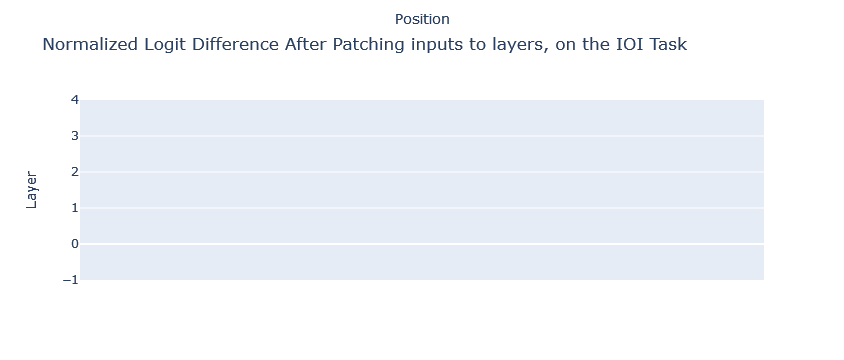

19.2002
19.2005
19.2006
19.2007
19.2010
19.2013
19.2016
19.2019
19.2020
19.2021
19.2022
19.2023
19.2024
19.2026
19.2030
19.2031
19.2033
19.2034
19.2036
19.2040
19.2044
19.2045
19.2046
20
20.11
20.17
20.18
20.19
20.22
20.34
20.50
20.59
20.60
20.62
20.64
20.70
20.77
20.82
20.96
20.99
20.102
20.104
20.127
20.128
20.129
20.136
20.153
20.154
20.162
20.176
20.185
20.186
20.191
20.200
20.210
20.211
20.217
20.222
20.225
20.226
20.232
20.237
20.239
20.256
20.266
20.280
20.287
20.288
20.290
20.292
20.293
20.297
20.314
20.315
20.317
20.320
20.326
20.345
20.347
20.355
20.360
20.363
20.367
20.369
20.382
20.383
20.426
20.433
20.435
20.436
20.437
20.455
20.459
20.465
20.469
20.477
20.485
20.491
20.493
20.512
20.515
20.516
20.522
20.526
20.527
20.534
20.535
20.544
20.547
20.550
20.556
20.558
20.566
20.572
20.573
20.574
20.575
20.577
20.580
20.587
20.593
20.599
20.607
20.609
20.624
20.626
20.629
20.635
20.637
20.652
20.654
20.662
20.666
20.670
20.673
20.677
20.679
20.685
20.687
20.691
20.693
20.694
20.

KeyboardInterrupt: 

In [13]:
# Visualize the results





In [19]:
from ipywidgets import interact

prompt_looking = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_looking = model.to_tokens(prompt_looking)
logits_looking, activations_looking = model.run_with_cache(prompt_tokens_looking)
token_labels_looking = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_looking[0]))]
L = len(token_labels_l_e)
EPS = 0.05
choices = []
for layer in range(model.cfg.n_layers):
    print(layer)
    for e in range(model.cfg.E):
        all_h = torch.zeros([model.cfg.N,L])
        for l in range(L):
            all_h[:,l]   =    activations[f'blocks.{layer}.hook_h.{l}'][0][e]
        if torch.any(torch.abs(all_h)>EPS):
            print(f'{layer}.{e}')

0
0.0
0.1
0.4
0.5
0.6
0.7
0.8
0.9
0.10
0.11
0.13
0.15
0.16
0.18
0.19
0.20
0.21
0.22
0.24
0.25
0.26
0.27
0.28
0.29
0.30
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.40
0.41
0.42
0.44
0.45
0.46
0.47
0.49
0.50
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.60
0.61
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.70
0.71
0.72
0.73
0.74
0.75
0.76
0.79
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.90
0.91
0.92
0.93
0.95
0.96
0.97
0.98
0.100
0.101
0.102
0.103
0.104
0.105
0.106
0.107
0.109
0.110
0.111
0.112
0.113
0.114
0.115
0.116
0.117
0.118
0.119
0.120
0.121
0.122
0.123
0.125
0.126
0.127
0.128
0.129
0.130
0.131
0.132
0.133
0.134
0.135
0.136
0.137
0.138
0.139
0.140
0.141
0.142
0.143
0.144
0.146
0.147
0.148
0.149
0.151
0.152
0.153
0.154
0.155
0.156
0.157
0.158
0.160
0.161
0.162
0.163
0.164
0.165
0.166
0.167
0.168
0.169
0.170
0.171
0.172
0.173
0.174
0.175
0.176
0.179
0.180
0.181
0.182
0.184
0.185
0.186
0.187
0.188
0.189
0.190
0.191
0.192
0.193
0.194
0.195
0.196
0.198
0.199
0.200
0.202
0.204
0.205
0.208


0.1595
0.1596
0.1598
0.1599
0.1600
0.1601
0.1602
0.1604
0.1605
0.1606
0.1607
0.1608
0.1609
0.1610
0.1611
0.1612
0.1613
0.1614
0.1615
0.1616
0.1618
0.1621
0.1622
0.1623
0.1624
0.1625
0.1627
0.1629
0.1630
0.1631
0.1632
0.1634
0.1635
0.1636
0.1637
0.1638
0.1639
0.1640
0.1641
0.1642
0.1643
0.1644
0.1645
0.1646
0.1647
0.1649
0.1650
0.1651
0.1652
0.1654
0.1655
0.1656
0.1657
0.1658
0.1659
0.1660
0.1662
0.1663
0.1664
0.1665
0.1666
0.1667
0.1668
0.1669
0.1670
0.1672
0.1673
0.1674
0.1675
0.1677
0.1679
0.1680
0.1681
0.1682
0.1683
0.1685
0.1686
0.1687
0.1688
0.1689
0.1691
0.1693
0.1694
0.1695
0.1696
0.1697
0.1698
0.1699
0.1700
0.1702
0.1703
0.1704
0.1705
0.1707
0.1708
0.1710
0.1711
0.1712
0.1713
0.1714
0.1715
0.1716
0.1717
0.1719
0.1720
0.1721
0.1722
0.1723
0.1725
0.1726
0.1728
0.1729
0.1730
0.1731
0.1732
0.1733
0.1734
0.1735
0.1736
0.1737
0.1738
0.1739
0.1741
0.1742
0.1743
0.1744
0.1745
0.1746
0.1747
0.1748
0.1749
0.1750
0.1751
0.1752
0.1753
0.1754
0.1755
0.1756
0.1757
0.1758
0.1759
0.1760
0.1762

6.977
6.978
6.980
6.986
6.1002
6.1003
6.1007
6.1010
6.1014
6.1021
6.1032
6.1033
6.1049
6.1051
6.1053
6.1061
6.1068
6.1070
6.1082
6.1093
6.1112
6.1120
6.1123
6.1147
6.1155
6.1167
6.1171
6.1174
6.1177
6.1179
6.1225
6.1234
6.1257
6.1290
6.1371
6.1380
6.1407
6.1414
6.1426
6.1430
6.1433
6.1436
6.1439
6.1455
6.1460
6.1478
6.1485
6.1491
6.1495
6.1501
6.1512
6.1513
6.1548
6.1551
6.1582
6.1594
6.1619
6.1623
6.1628
6.1631
6.1638
6.1714
6.1723
6.1731
6.1733
6.1745
6.1769
6.1773
6.1777
6.1829
6.1833
6.1834
6.1837
6.1842
6.1859
6.1861
6.1872
6.1900
6.1922
6.1939
6.1940
6.1948
6.1965
6.1981
6.1985
6.2024
6.2033
7
7.13
7.15
7.59
7.67
7.77
7.82
7.97
7.116
7.139
7.187
7.206
7.221
7.250
7.264
7.297
7.302
7.318
7.344
7.350
7.358
7.361
7.381
7.403
7.414
7.439
7.503
7.549
7.557
7.560
7.575
7.583
7.586
7.614
7.630
7.673
7.700
7.763
7.777
7.785
7.788
7.815
7.832
7.833
7.862
7.885
7.899
7.902
7.928
7.936
7.938
7.970
7.983
7.1006
7.1019
7.1026
7.1043
7.1050
7.1067
7.1078
7.1088
7.1119
7.1124
7.1135
7.1164
7.11

12.558
12.566
12.572
12.583
12.585
12.591
12.592
12.596
12.603
12.607
12.608
12.615
12.629
12.630
12.631
12.641
12.646
12.647
12.652
12.679
12.681
12.694
12.709
12.710
12.713
12.715
12.721
12.723
12.724
12.727
12.730
12.736
12.739
12.741
12.759
12.765
12.768
12.784
12.795
12.796
12.797
12.798
12.799
12.802
12.804
12.817
12.818
12.827
12.831
12.842
12.843
12.844
12.857
12.858
12.859
12.861
12.867
12.872
12.875
12.878
12.885
12.889
12.896
12.901
12.902
12.903
12.913
12.921
12.929
12.939
12.943
12.954
12.957
12.959
12.973
12.980
12.983
12.985
12.989
12.990
12.1005
12.1025
12.1028
12.1030
12.1043
12.1045
12.1047
12.1048
12.1052
12.1069
12.1071
12.1089
12.1092
12.1093
12.1101
12.1108
12.1113
12.1114
12.1137
12.1141
12.1147
12.1148
12.1149
12.1152
12.1153
12.1157
12.1164
12.1168
12.1174
12.1175
12.1179
12.1190
12.1195
12.1196
12.1202
12.1203
12.1207
12.1211
12.1214
12.1221
12.1226
12.1227
12.1231
12.1239
12.1249
12.1251
12.1260
12.1269
12.1272
12.1275
12.1312
12.1329
12.1332
12.1334
12.1335


15.1248
15.1250
15.1251
15.1265
15.1276
15.1278
15.1284
15.1287
15.1291
15.1292
15.1293
15.1297
15.1299
15.1304
15.1310
15.1313
15.1314
15.1322
15.1328
15.1331
15.1333
15.1335
15.1339
15.1346
15.1347
15.1348
15.1351
15.1352
15.1360
15.1378
15.1387
15.1391
15.1393
15.1396
15.1405
15.1411
15.1413
15.1414
15.1421
15.1422
15.1426
15.1433
15.1438
15.1446
15.1447
15.1452
15.1454
15.1457
15.1463
15.1464
15.1471
15.1472
15.1474
15.1478
15.1494
15.1503
15.1508
15.1512
15.1513
15.1514
15.1517
15.1522
15.1528
15.1529
15.1540
15.1545
15.1548
15.1557
15.1558
15.1561
15.1568
15.1570
15.1571
15.1575
15.1579
15.1580
15.1587
15.1598
15.1601
15.1605
15.1607
15.1610
15.1621
15.1625
15.1626
15.1628
15.1631
15.1637
15.1639
15.1649
15.1653
15.1659
15.1670
15.1673
15.1682
15.1684
15.1687
15.1691
15.1696
15.1697
15.1700
15.1704
15.1705
15.1706
15.1708
15.1711
15.1713
15.1718
15.1720
15.1724
15.1725
15.1726
15.1731
15.1738
15.1742
15.1745
15.1750
15.1753
15.1760
15.1773
15.1778
15.1782
15.1802
15.1803
15.1812


18.311
18.315
18.322
18.325
18.326
18.327
18.330
18.332
18.339
18.342
18.343
18.352
18.361
18.363
18.367
18.368
18.373
18.375
18.384
18.386
18.388
18.395
18.400
18.402
18.403
18.409
18.411
18.414
18.415
18.418
18.421
18.426
18.427
18.436
18.444
18.445
18.458
18.459
18.460
18.463
18.470
18.473
18.474
18.482
18.489
18.491
18.492
18.496
18.502
18.505
18.518
18.521
18.522
18.524
18.525
18.527
18.530
18.533
18.535
18.542
18.556
18.557
18.558
18.567
18.583
18.584
18.587
18.588
18.590
18.595
18.596
18.603
18.612
18.615
18.618
18.620
18.624
18.626
18.632
18.634
18.648
18.655
18.657
18.664
18.666
18.669
18.670
18.671
18.673
18.675
18.681
18.682
18.684
18.691
18.693
18.694
18.696
18.708
18.713
18.714
18.716
18.724
18.725
18.726
18.732
18.740
18.743
18.746
18.747
18.754
18.756
18.758
18.761
18.764
18.770
18.778
18.779
18.781
18.789
18.792
18.794
18.795
18.796
18.799
18.804
18.805
18.807
18.809
18.811
18.816
18.822
18.831
18.832
18.833
18.839
18.841
18.846
18.850
18.852
18.854
18.858
18.864
18.866

19.2002
19.2005
19.2006
19.2007
19.2010
19.2013
19.2016
19.2019
19.2020
19.2021
19.2022
19.2023
19.2024
19.2026
19.2030
19.2031
19.2033
19.2034
19.2036
19.2040
19.2044
19.2045
19.2046
20
20.11
20.17
20.18
20.19
20.22
20.34
20.50
20.59
20.60
20.62
20.64
20.70
20.77
20.82
20.96
20.99
20.102
20.104
20.127
20.128
20.129
20.136
20.153
20.154
20.162
20.176
20.185
20.186
20.191
20.200
20.210
20.211
20.217
20.222
20.225
20.226
20.232
20.237
20.239
20.256
20.266
20.280
20.287
20.288
20.290
20.292
20.293
20.297
20.314
20.315
20.317
20.320
20.326
20.345
20.347
20.355
20.360
20.363
20.367
20.369
20.382
20.383
20.426
20.433
20.435
20.436
20.437
20.455
20.459
20.465
20.469
20.477
20.485
20.491
20.493
20.512
20.515
20.516
20.522
20.526
20.527
20.534
20.535
20.544
20.547
20.550
20.556
20.558
20.566
20.572
20.573
20.574
20.575
20.577
20.580
20.587
20.593
20.599
20.607
20.609
20.624
20.626
20.629
20.635
20.637
20.652
20.654
20.662
20.666
20.670
20.673
20.677
20.679
20.685
20.687
20.691
20.693
20.694
20.

KeyboardInterrupt: 